Regenerating datasets with proper parameters...
GENERATING PROPER AINTERN DATASETS

Generating Dataset 1: mg_train_match
Parameters: β=0.25, γ=0.1, τ=15
  - Generated 100 samples
  - Range: [0.230, 0.789]
  ✓ Range looks good for quantum encoding

Generating Dataset 2: mg_slight_variant
Parameters: β=0.22, γ=0.12, τ=17
  - Generated 100 samples
  - Range: [0.233, 0.799]
  ✓ Range looks good for quantum encoding


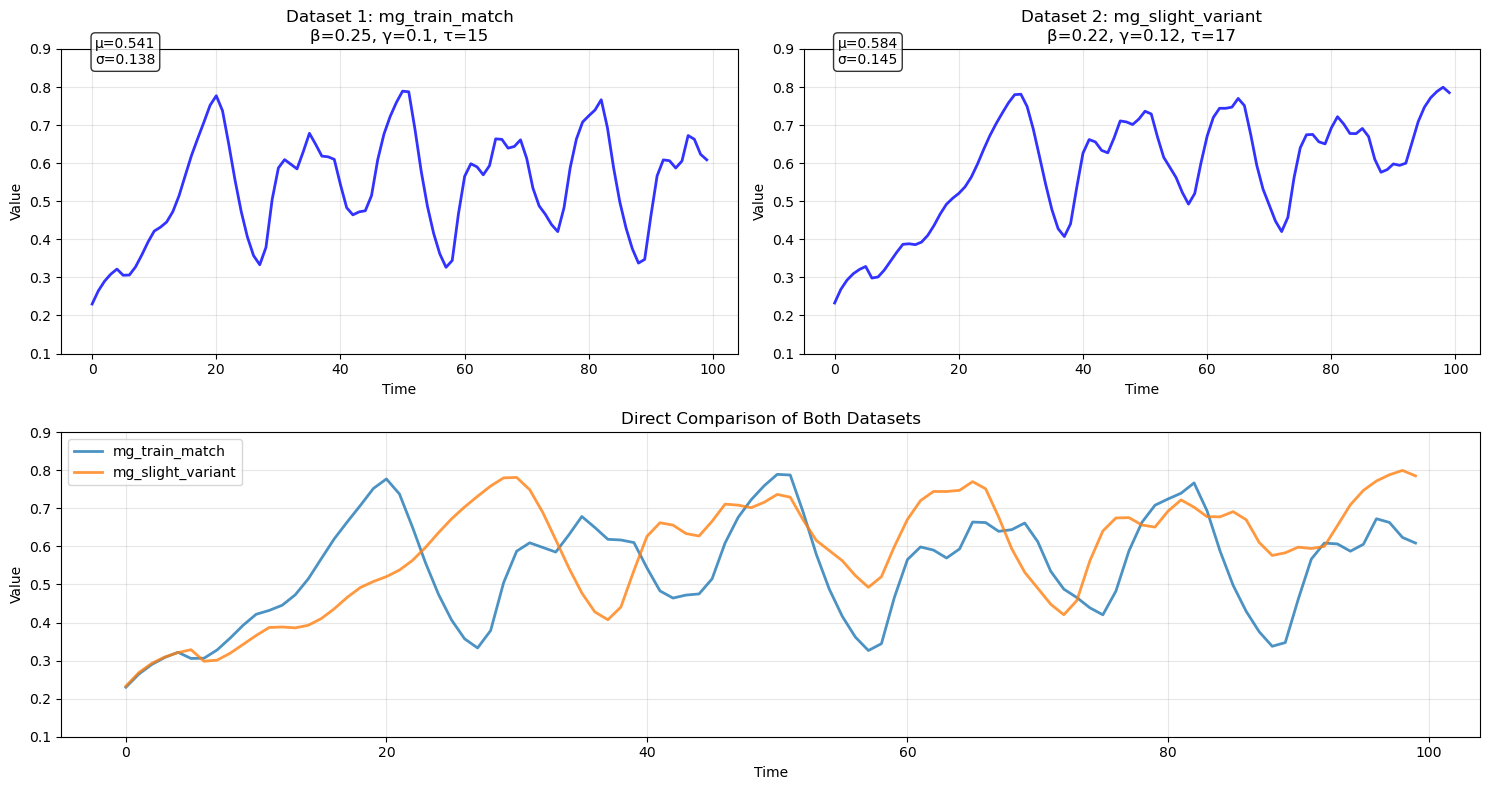


Improved datasets ready for comparison!
These should be much closer to your training data distribution.


In [5]:
# AIntern Framework: Proper Dataset Generation Based on Existing Method
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from datetime import datetime

# Add path for qae_utils
sys.path.append('/Users/jacobzwoniarski/Desktop/qae_architectures')

from qae_utils.Files import create_folder_if_needed, write_json_file, write_ts_file
from sklearn.preprocessing import MinMaxScaler

def scale_values(x, new_min=0, new_max=1):
    """Scale values to new range"""
    x_min, x_max = np.min(x), np.max(x)
    return new_min + (x - x_min) * (new_max - new_min) / (x_max - x_min)

def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    """Generate Mackey-Glass time series using your exact method"""
    N = int(T / dt)                # Total number of time steps
    delay_steps = int(tau / dt)    # Delay in terms of steps
    x = np.zeros(N + delay_steps)  # Initialize time series with zeros
    x[0:delay_steps] = 1.2         # Initial condition

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]  # Delayed term
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]  # Mackey-Glass equation
        x[t + 1] = x[t] + dxdt * dt  # Euler integration

    return x[delay_steps:]  # Return only the valid part

def generate_proper_aintern_datasets():
    """Generate datasets that are closer to your original training conditions"""
    
    print("GENERATING PROPER AINTERN DATASETS")
    print("=" * 50)
    
    # Common settings (matching your original data generation)
    margin = 0.2
    scale_low = 0 + margin
    scale_high = 1 - margin
    dt = 1.0
    T = 300
    
    # Dataset 1: Exact match to your training data parameters
    dataset_1_params = {
        'beta': 0.25,    # Your exact training parameters
        'gamma': 0.1, 
        'n': 10,
        'tau': 15,       # Your exact tau
        'dt': dt,
        'T': T,
        'name': 'mg_train_match'
    }
    
    # Dataset 2: Slight variation (staying close to training distribution)
    dataset_2_params = {
        'beta': 0.22,    # Small change
        'gamma': 0.12,   # Small change
        'n': 10,         # Keep same
        'tau': 17,       # Small change (17 vs 15)
        'dt': dt,
        'T': T,
        'name': 'mg_slight_variant'
    }
    
    datasets = {}
    
    for i, params in enumerate([dataset_1_params, dataset_2_params], 1):
        print(f"\nGenerating Dataset {i}: {params['name']}")
        print(f"Parameters: β={params['beta']}, γ={params['gamma']}, τ={params['tau']}")
        
        # Generate time series
        y_raw = mackey_glass(
            beta=params['beta'],
            gamma=params['gamma'], 
            n=params['n'],
            tau=params['tau'],
            dt=params['dt'],
            T=params['T']
        )
        
        # Scale and subsample (following your exact method)
        y_raw = scale_values(y_raw, new_min=scale_low, new_max=scale_high)
        y = y_raw[2::3]  # Your exact subsampling
        X = np.array([i for i in range(len(y))])
        
        print(f"  - Generated {len(y)} samples")
        print(f"  - Range: [{np.min(y):.3f}, {np.max(y):.3f}]")
        
        # Check if the range is reasonable (should be close to [0.2, 0.8])
        if np.min(y) < 0.1 or np.max(y) > 0.9:
            print(f"  ⚠️  WARNING: Range seems unusual for these parameters")
        else:
            print(f"  ✓ Range looks good for quantum encoding")
        
        # Store dataset
        datasets[params['name']] = {
            'X': X,
            'y': y,
            'params': params,
            'info': {
                'data_name': f"mackey_glass_{params['name']}",
                'samples': len(y),
                'scale_low': scale_low,
                'scale_high': scale_high,
                'scale_margin': margin,
                **{f"mackey_glass_{k}": v for k, v in params.items() if k != 'name'}
            }
        }
    
    return datasets

# Regenerate with proper parameters
print("Regenerating datasets with proper parameters...")
datasets = generate_proper_aintern_datasets()

# Visualize both datasets
plt.figure(figsize=(15, 8))

for i, (name, data) in enumerate(datasets.items(), 1):
    plt.subplot(2, 2, i)
    plt.plot(data['X'], data['y'], linewidth=2, alpha=0.8, color='blue')
    plt.title(f"Dataset {i}: {name}\nβ={data['params']['beta']}, γ={data['params']['gamma']}, τ={data['params']['tau']}")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.ylim([0.1, 0.9])  # Set consistent y-axis for comparison
    
    # Add statistics
    mean_val = np.mean(data['y'])
    std_val = np.std(data['y'])
    plt.text(0.05, 0.95, f'μ={mean_val:.3f}\nσ={std_val:.3f}', 
             transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Add comparison plot
plt.subplot(2, 2, (3, 4))
for name, data in datasets.items():
    plt.plot(data['X'], data['y'], linewidth=2, alpha=0.8, label=name)

plt.title('Direct Comparison of Both Datasets')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0.1, 0.9])

plt.tight_layout()
plt.show()

print(f"\nImproved datasets ready for comparison!")
print("These should be much closer to your training data distribution.")

In [6]:
# Flexible Full QAE Model Comparison Framework
import json
import pennylane as qml
from pennylane import numpy as pnp

class FullQAEComparator:
    """
    Flexible comparison framework for Full QAE models
    Can load and compare any Full QAE models (yours, mentor's, future ones)
    """
    
    def __init__(self, n_qubits=4):
        self.n_qubits = n_qubits
        self.n_latent = 2
        self.n_trash = n_qubits - 2
        self.dev = qml.device('default.qubit', wires=n_qubits)
        self.loaded_models = {}
        
    def load_full_qae_model(self, model_path, model_name):
        """Load a Full QAE model from JSON file"""
        try:
            with open(model_path, 'r') as f:
                model_data = json.load(f)
            
            # Extract parameters
            encoder_params = pnp.array(model_data['model_parameters']['encoder_params'], requires_grad=False)
            decoder_params = pnp.array(model_data['model_parameters']['decoder_params'], requires_grad=False)
            
            # Create circuit for this model
            @qml.qnode(self.dev, diff_method="backprop")
            def model_circuit(x):
                # Encoder (adjoint-based)
                for i, val in enumerate(x[:self.n_qubits]):
                    qml.RY(val * np.pi, wires=i)
                qml.adjoint(self._decoder_template)(encoder_params)
                
                # Decoder
                self._decoder_template(decoder_params)
                
                return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]
            
            self.loaded_models[model_name] = {
                'circuit': model_circuit,
                'encoder_params': encoder_params,
                'decoder_params': decoder_params,
                'metadata': model_data['model_info'],
                'performance': model_data['performance_metrics'],
                'timestamp': model_data['model_info']['timestamp'],
                'path': model_path
            }
            
            print(f"✓ Loaded model: {model_name}")
            print(f"  - Timestamp: {model_data['model_info']['timestamp']}")
            print(f"  - Training improvement: {model_data['performance_metrics']['training']['mse_improvement_pct']:.1f}%")
            print(f"  - Test improvement: {model_data['performance_metrics']['test']['mse_improvement_pct']:.1f}%")
            
            return True
            
        except Exception as e:
            print(f"✗ Failed to load {model_name}: {e}")
            return False
    
    def _decoder_template(self, params):
        """Decoder template used in circuits"""
        n_layers = len(params) // (self.n_qubits * 3)
        
        for layer in range(n_layers):
            # Reverse entanglement
            qml.CNOT(wires=[self.n_qubits - 1, 0])
            for i in range(self.n_qubits - 2, -1, -1):
                qml.CNOT(wires=[i + 1, i])
            
            # Rotations
            for i in range(self.n_qubits):
                idx = layer * self.n_qubits * 3 + i * 3
                qml.RZ(params[idx + 2], wires=i)
                qml.RY(params[idx + 1], wires=i)
                qml.RX(params[idx], wires=i)
    
    def compare_models_on_dataset(self, dataset_name, dataset, models_to_compare=None, n_samples=20):
        """Compare loaded models on a specific dataset"""
        
        if models_to_compare is None:
            models_to_compare = list(self.loaded_models.keys())
        
        print(f"\nCOMPARING MODELS ON {dataset_name.upper()}")
        print("=" * 60)
        
        # Prepare test data
        y = dataset['y']
        info = dataset['info']
        noise_level = 0.2
        
        # Create windows (same as your method)
        wind_size = self.n_qubits
        wind_step = 1
        pure_windows = self._create_windows(y, wind_size, wind_step)
        
        # Split (same 75% as your training)
        split_idx = int(len(pure_windows) * 0.75)
        test_windows = pure_windows[split_idx:]
        
        n_test = min(n_samples, len(test_windows))
        
        # Test each model
        results = {}
        
        for model_name in models_to_compare:
            if model_name not in self.loaded_models:
                print(f"Warning: Model {model_name} not loaded, skipping...")
                continue
                
            print(f"\nTesting {model_name}...")
            
            model_circuit = self.loaded_models[model_name]['circuit']
            improvements = []
            mse_values = []
            
            for i in range(n_test):
                clean_target = test_windows[i]
                noisy_input = self._add_noise(clean_target, noise_level, info)
                
                # Get model output
                model_output_raw = model_circuit(noisy_input)
                model_output = self._scale_output(model_output_raw, info)
                
                # Calculate metrics
                noise_mse = np.mean((clean_target - noisy_input)**2)
                model_mse = np.mean((clean_target - model_output)**2)
                improvement = (noise_mse - model_mse) / noise_mse * 100
                
                improvements.append(improvement)
                mse_values.append(model_mse)
            
            # Store results
            results[model_name] = {
                'improvements': improvements,
                'mse_values': mse_values,
                'avg_improvement': np.mean(improvements),
                'std_improvement': np.std(improvements),
                'avg_mse': np.mean(mse_values),
                'success_rate': sum(1 for x in improvements if x > 0) / len(improvements) * 100
            }
            
            print(f"  - Average improvement: {results[model_name]['avg_improvement']:.1f}%")
            print(f"  - Success rate: {results[model_name]['success_rate']:.1f}%")
        
        return results
    
    def _create_windows(self, ts, wind_size, wind_step):
        """Create sliding windows"""
        return np.array([ts[i:i+wind_size] for i in range(0, len(ts)-wind_size+1, wind_step)])
    
    def _add_noise(self, data, noise_level, info):
        """Add scaled noise"""
        data_range = info['scale_high'] - info['scale_low']
        noise = noise_level * data_range * np.random.normal(size=len(data))
        return np.clip(data + noise, info['scale_low'], info['scale_high'])
    
    def _scale_output(self, raw_output, info):
        """Scale quantum output to data range"""
        return [(float(o) + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low'] 
                for o in raw_output]

# Initialize the comparator
comparator = FullQAEComparator(n_qubits=4)

print("Full QAE Comparison Framework Ready!")
print("You can now load models and compare them across different datasets.")

Full QAE Comparison Framework Ready!
You can now load models and compare them across different datasets.


In [7]:
# Load Your Existing Full QAE Models
DATA_PATH = '../jacobs_examples/aintern/data/mackey_glass_n100'

# Model paths (update these to your actual paths)
model_paths = {
    'FullQAE_Aug03': f'{DATA_PATH}/full_qae_complete_model_20250803_154745.json',
    'FullQAE_Aug08': f'{DATA_PATH}/full_qae_complete_model_20250808_101536.json'
}

# Load models
loaded_count = 0
for model_name, model_path in model_paths.items():
    if os.path.exists(model_path):
        if comparator.load_full_qae_model(model_path, model_name):
            loaded_count += 1
    else:
        print(f"Warning: Model file not found: {model_path}")

print(f"\nSuccessfully loaded {loaded_count} models for comparison")
if loaded_count > 0:
    print("Available models:", list(comparator.loaded_models.keys()))

✓ Loaded model: FullQAE_Aug03
  - Timestamp: 2025-08-03T15:47:45.204425
  - Training improvement: 55.3%
  - Test improvement: 51.8%
✓ Loaded model: FullQAE_Aug08
  - Timestamp: 2025-08-08T10:15:36.423565
  - Training improvement: 55.8%
  - Test improvement: 62.9%

Successfully loaded 2 models for comparison
Available models: ['FullQAE_Aug03', 'FullQAE_Aug08']


In [8]:
# Compare Models Across Both Datasets
print("Running comprehensive model comparison...")

all_results = {}

# Test on both datasets
for dataset_name, dataset in datasets.items():
    print(f"\n{'='*60}")
    print(f"TESTING ON DATASET: {dataset_name.upper()}")
    print(f"{'='*60}")
    
    results = comparator.compare_models_on_dataset(
        dataset_name, 
        dataset, 
        n_samples=15  # AIntern-appropriate sample size
    )
    
    all_results[dataset_name] = results

# Statistical comparison between models
from scipy import stats

def statistical_comparison_aintern(results_1, results_2, model_1_name, model_2_name, alpha=0.05):
    """Statistical comparison using p-values as mentor requested"""
    
    improvements_1 = results_1['improvements']
    improvements_2 = results_2['improvements']
    
    # Mann-Whitney U test
    statistic, p_value = stats.mannwhitneyu(improvements_1, improvements_2, alternative='two-sided')
    
    # Effect size
    mean_1 = np.mean(improvements_1)
    mean_2 = np.mean(improvements_2)
    pooled_std = np.sqrt((np.var(improvements_1) + np.var(improvements_2)) / 2)
    cohens_d = (mean_1 - mean_2) / pooled_std if pooled_std > 0 else 0
    
    # Results
    significance = "SIGNIFICANT" if p_value < alpha else "NOT SIGNIFICANT"
    better_model = model_1_name if mean_1 > mean_2 else model_2_name
    
    print(f"\nSTATISTICAL COMPARISON: {model_1_name} vs {model_2_name}")
    print("-" * 50)
    print(f"p-value: {p_value:.4f}")
    print(f"Significance: {significance} (α = {alpha})")
    print(f"Effect size (Cohen's d): {cohens_d:.3f}")
    print(f"Better model: {better_model}")
    
    return {
        'p_value': p_value,
        'significant': p_value < alpha,
        'better_model': better_model,
        'cohens_d': cohens_d
    }

# Run statistical comparisons if we have both models
if len(comparator.loaded_models) >= 2:
    model_names = list(comparator.loaded_models.keys())
    
    for dataset_name in all_results.keys():
        print(f"\n{'='*50}")
        print(f"STATISTICAL ANALYSIS: {dataset_name.upper()}")
        print(f"{'='*50}")
        
        dataset_results = all_results[dataset_name]
        if len(dataset_results) >= 2:
            model_1, model_2 = list(dataset_results.keys())[:2]
            statistical_comparison_aintern(
                dataset_results[model_1], 
                dataset_results[model_2],
                model_1, 
                model_2
            )

Running comprehensive model comparison...

TESTING ON DATASET: MG_TRAIN_MATCH

COMPARING MODELS ON MG_TRAIN_MATCH

Testing FullQAE_Aug03...
  - Average improvement: 0.9%
  - Success rate: 66.7%

Testing FullQAE_Aug08...
  - Average improvement: 40.9%
  - Success rate: 86.7%

TESTING ON DATASET: MG_SLIGHT_VARIANT

COMPARING MODELS ON MG_SLIGHT_VARIANT

Testing FullQAE_Aug03...
  - Average improvement: 60.7%
  - Success rate: 93.3%

Testing FullQAE_Aug08...
  - Average improvement: 73.5%
  - Success rate: 100.0%

STATISTICAL ANALYSIS: MG_TRAIN_MATCH

STATISTICAL COMPARISON: FullQAE_Aug03 vs FullQAE_Aug08
--------------------------------------------------
p-value: 0.5069
Significance: NOT SIGNIFICANT (α = 0.05)
Effect size (Cohen's d): -0.501
Better model: FullQAE_Aug08

STATISTICAL ANALYSIS: MG_SLIGHT_VARIANT

STATISTICAL COMPARISON: FullQAE_Aug03 vs FullQAE_Aug08
--------------------------------------------------
p-value: 0.1711
Significance: NOT SIGNIFICANT (α = 0.05)
Effect size (Cohe

In [10]:
# Add debugging to the comparison method
def debug_model_comparison(comparator, dataset_name, dataset, model_name, n_samples=5):
    """Debug what's happening in model comparison"""
    
    print(f"DEBUGGING {model_name} on {dataset_name}")
    print("-" * 40)
    
    y = dataset['y']
    info = dataset['info']
    noise_level = 0.2
    
    # Create windows
    wind_size = comparator.n_qubits
    wind_step = 1
    pure_windows = comparator._create_windows(y, wind_size, wind_step)
    
    # Split
    split_idx = int(len(pure_windows) * 0.75)
    test_windows = pure_windows[split_idx:]
    
    print(f"Total windows: {len(pure_windows)}")
    print(f"Test windows: {len(test_windows)}")
    print(f"Using {min(n_samples, len(test_windows))} samples for debugging")
    
    model_circuit = comparator.loaded_models[model_name]['circuit']
    
    for i in range(min(n_samples, len(test_windows))):
        clean_target = test_windows[i]
        noisy_input = comparator._add_noise(clean_target, noise_level, info)
        
        print(f"\nSample {i+1}:")
        print(f"  Clean target: {clean_target}")
        print(f"  Noisy input:  {noisy_input}")
        print(f"  Noise level:  {np.mean((clean_target - noisy_input)**2):.6f}")
        
        # Get model output
        model_output_raw = model_circuit(noisy_input)
        model_output = comparator._scale_output(model_output_raw, info)
        
        print(f"  Raw output:   {[f'{x:.3f}' for x in model_output_raw]}")
        print(f"  Scaled output: {model_output}")
        
        # Calculate metrics
        noise_mse = np.mean((clean_target - noisy_input)**2)
        model_mse = np.mean((clean_target - model_output)**2)
        improvement = (noise_mse - model_mse) / noise_mse * 100
        
        print(f"  Noise MSE:    {noise_mse:.6f}")
        print(f"  Model MSE:    {model_mse:.6f}")
        print(f"  Improvement:  {improvement:.1f}%")
        
        if model_mse > noise_mse * 2:  # If model is much worse than noise
            print(f"  ⚠️  WARNING: Model performing much worse than noise!")

# Run debugging on the problematic dataset
if len(comparator.loaded_models) > 0:
    model_name = list(comparator.loaded_models.keys())[0]
    
    print("DEBUGGING ON ORIGINAL DATASETS:")
    for dataset_name, dataset in datasets.items():
        debug_model_comparison(comparator, dataset_name, dataset, model_name, n_samples=3)

DEBUGGING ON ORIGINAL DATASETS:
DEBUGGING FullQAE_Aug03 on mg_train_match
----------------------------------------
Total windows: 97
Test windows: 25
Using 3 samples for debugging

Sample 1:
  Clean target: [0.48771539 0.4655766  0.4386011  0.42020895]
  Noisy input:  [0.6586928  0.37111469 0.47196271 0.58802349]
  Noise level:  0.016858
  Raw output:   ['0.329', '0.069', '0.095', '0.160']
  Scaled output: [0.598633977673722, 0.520579313802676, 0.5285333791925985, 0.5478870857570407]
  Noise MSE:    0.016858
  Model MSE:    0.009929
  Improvement:  41.1%

Sample 2:
  Clean target: [0.4655766  0.4386011  0.42020895 0.48242899]
  Noisy input:  [0.25601137 0.35895348 0.41031062 0.43701633]
  Noise level:  0.013105
  Raw output:   ['-0.483', '-0.417', '-0.347', '-0.243']
  Scaled output: [0.35502211206180356, 0.3749251091207394, 0.39596352886947545, 0.4269875685693481]
  Noise MSE:    0.013105
  Model MSE:    0.004985
  Improvement:  62.0%

Sample 3:
  Clean target: [0.4386011  0.42020895 